# Carmi and John Go for a Walk

*An exploration of movie data using SQL*

## Business Problem

Microsoft sees all the big companies creating original video content, and have decided to create a new movie studio. To do so, they want to better understand the movie industry by exploring what type of films are currently doing the best at the box office.

This book will examine how movies' worldwide gross is impacted by the following parameters:

- **Film characteristics**:  
-- by genre  
-- by release date
- **Film personnel**:  
-- by talent  
-- by director

## Data

Our data come from publicly available online databases about movies, including IMDB, TMBD, and Rotten Tomatoes. These have been combined into a single SQL database.

We begin by importing all the requisite libraries and setting up the MySQL connection.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
%matplotlib inline

conn = mysql.connector.connect(user='hbs-student', password='super-secure-password?',
                              host='hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com',
                              database='movies')

## (1) Genre

Which genres make the most at the box office?

To answer this question, we need to combine the data from two separate data tables: one from IMDB and one from TN. The tables are joined by both movie title and release year, in order to avoid incorrect joins on identically titled but otherwise distinct movies. Secondly, the data must be cleaned, as the box office data are given as strings including dollar signs and commas.

In [27]:
df = pd.read_sql_query('''
    SELECT movie,
           start_year,
           runtime_minutes,
           genres,
           CAST(REPLACE(REPLACE(production_budget, '$', ''), ',' ,'') AS UNSIGNED) AS productionBudget, 
           CAST(REPLACE(REPLACE(worldwide_gross, '$', ''), ',' ,'') AS UNSIGNED) AS worldwideGross
    FROM imdb_title_basics
    JOIN tn_movie_budgets
    ON imdb_title_basics.primary_title = tn_movie_budgets.movie
    AND imdb_title_basics.start_year = SUBSTRING(tn_movie_budgets.release_date, -4, 4)
''', conn)

A movie can have several genres, and all are entered as a single entry in each row. We get around this using the one-hot encoding method, which retains each movie as a single row, at the expense of requiring many columns.

In [28]:
df['genre_count'] = None
for i in range(len(df['genres'])):
    if df['genres'][i].split(',') == ['']:
        df['genre_count'][i] = 0
    else:
        df['genre_count'][i] = len(df['genres'][i].split(','))

/Users/carmimedoff/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carmimedoff/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [29]:
all_genres = []
for i in range(len(df['genres'])):
    all_genres.extend(df['genres'][i].split(','))
all_genres = set(all_genres)
all_genres.remove('')

for i in set(all_genres):
    df[i] = 0

for i in range(len(df['genres'])):
    for j in set(all_genres):
        if j in df['genres'][i].split(','):
            df[j][i] = 1

df.head()

/Users/carmimedoff/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,movie,start_year,runtime_minutes,genres,productionBudget,worldwideGross,genre_count,Comedy,Romance,Mystery,...,History,Sport,Reality-TV,Family,Animation,War,Drama,Adventure,Crime,Thriller
0,Pirates of the Caribbean: On Stranger Tides,2011,136.0,"Action,Adventure,Fantasy",410600000,1045663875,3,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",350000000,149762350,3,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,Avengers: Age of Ultron,2015,141.0,"Action,Adventure,Sci-Fi",330600000,1403013963,3,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",300000000,2048134200,3,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Justice League,2017,120.0,"Action,Adventure,Fantasy",300000000,655945209,3,0,0,0,...,0,0,0,0,0,0,0,1,0,0


We now have a wide-form table with genres laid out using one-hot encoding.

Next, we transmute the table such that the genres become the new indices, with the numerical data grouped accordingly. Runtime minutes becomes unmeaningful while start year becomes entirely nonsensical, but the budget and gross figures we care about are still significant.

In [30]:
df_mod = df.melt(id_vars=['movie', 'start_year', 'runtime_minutes', 'genres', 'productionBudget', 'worldwideGross', 'genre_count'],
        var_name='genre').groupby(['genre','value']).sum().filter(like='1', axis=0).sort_values(by='worldwideGross', ascending=False).droplevel(1)
df_mod

,start_year,runtime_minutes,productionBudget,worldwideGross
genre,,,,
Adventure,727156,39756.0,38110490000,124421726769
Action,934549,51505.0,36229030000,108292491266
Comedy,1081325,54674.0,21664075000,70676957794
Drama,1532577,83674.0,20169003950,54721682970
Sci-Fi,275969,15635.0,12654970000,46161517065
Animation,213518,9940.0,10251500000,38938423745
Fantasy,259790,14324.0,10938750000,31030593027
Thriller,547767,28387.0,8731884950,30156968611
Crime,481334,26014.0,7712550000,19128986642


We are now ready to plot this data.

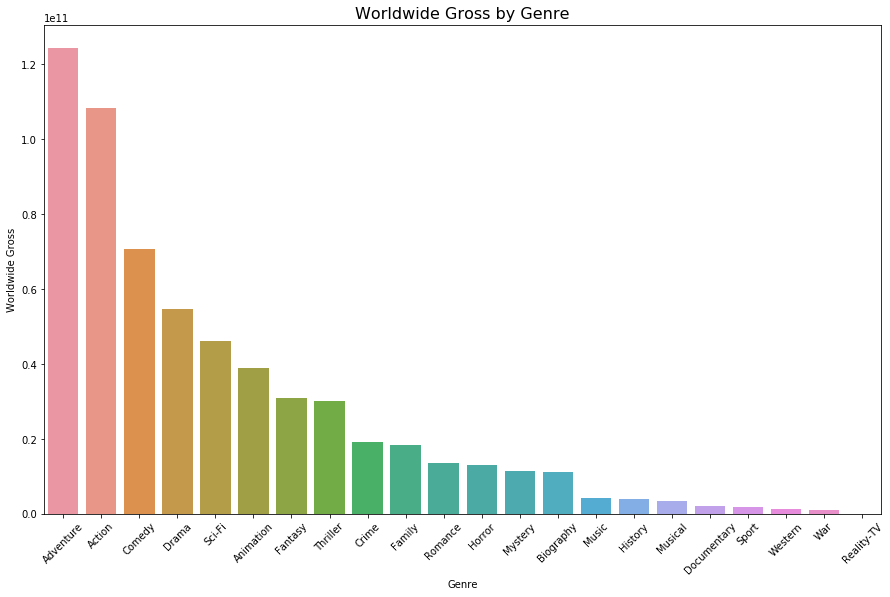

In [31]:
plt.figure(figsize=(15,9))
sns.barplot(df_mod.index, df_mod.worldwideGross)
plt.xlabel("Genre")
plt.ylabel("Worldwide Gross")
plt.title("Worldwide Gross by Genre",fontsize=16)
plt.xticks(rotation=45)
plt.show()

**Adventure** and **Action** films far outrank other genres at the box office. **Comedy** trails a distant third, while **Drama** and others form a long tail.

### Per-movie Basis

What if we wanted to measure this on a per movie basis? Would the results be the same?

To do so, we have to create a new metric that counts the number of movies of each genre. Below, this is done by creating a new dataframe, and joining it to the existing one.

In [7]:
data = {'genre': list(all_genres), 'movies': None}
genre_movies = pd.DataFrame(data)
genre_movies = genre_movies.set_index('genre')
for i in all_genres:
    genre_movies['movies'][i] = df[i].sum()
genre_movies

df_mod = df_mod.join(genre_movies, how='inner', on='genre')
df_mod['per_movie_gross'] = df_mod.worldwideGross / df_mod.movies
df_mod = df_mod.sort_values(by='per_movie_gross', ascending=False)
df_mod

,start_year,runtime_minutes,productionBudget,worldwideGross,movies,per_movie_gross
genre,,,,,,
Animation,213518,9940.0,10251500000,38938423745,106,3.67344e+08
Adventure,727156,39756.0,38110490000,124421726769,361,3.44659e+08
Sci-Fi,275969,15635.0,12654970000,46161517065,137,3.36945e+08
Musical,22138,1299.0,653350000,3316654091,11,3.01514e+08
Fantasy,259790,14324.0,10938750000,31030593027,129,2.40547e+08
Action,934549,51505.0,36229030000,108292491266,464,2.33389e+08
Family,195303,10034.0,6363250000,18271262367,97,1.88364e+08
Comedy,1081325,54674.0,21664075000,70676957794,537,1.31614e+08
Thriller,547767,28387.0,8731884950,30156968611,272,1.10871e+08


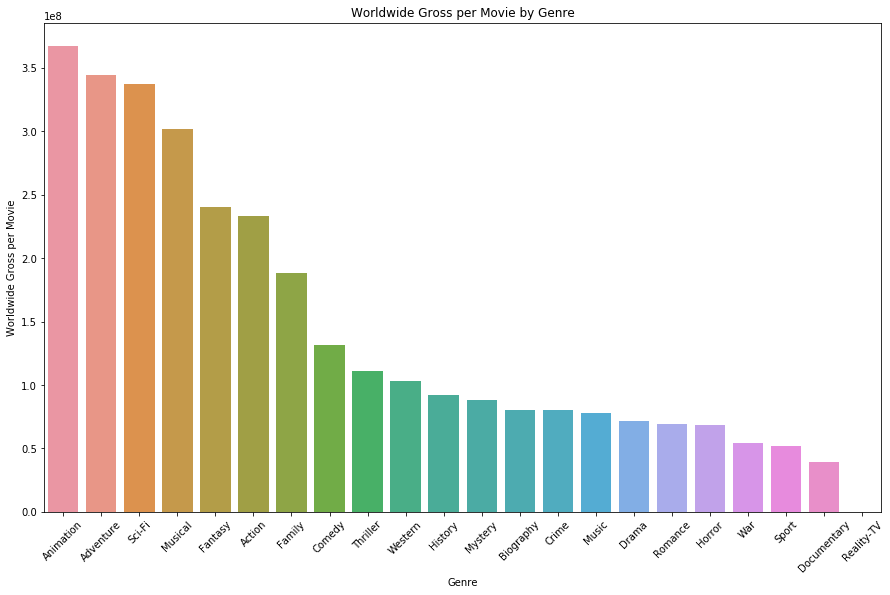

In [8]:
plt.figure(figsize=(15,9))
sns.barplot(df_mod.index, df_mod.per_movie_gross)
plt.xlabel("Genre")
plt.ylabel("Worldwide Gross per Movie")
plt.title("Worldwide Gross per Movie by Genre")
plt.xticks(rotation=45)
plt.show()

Here we see that on a per-movie basis, **Adventure** is still among the highest grossing. However, **Animation** and **Sci-Fi** have now also skyrocketed to being top performers, closely followed by **Musical**. **Action**, on the other hand, still does well, but has clearly trailed to a lower tier of performance.

**Microsoft should therefore focus on producing Adventure films.**

## (2) Release Month

Which release month makes the most at the box office?

To answer this question, we luckily need only look at one data table, as the TN data table includes both gross and release month. As above, the gross data needs to be cleaned and cast into a numerical format. Moreover, the month has to be parsed out from the date string.

In [9]:
df = pd.read_sql_query('''
    SELECT SUBSTRING(release_date, 1, 3) AS release_month,
           count(id) AS movies_released,
           CAST(REPLACE(REPLACE(production_budget, '$', ''), ',' ,'') AS UNSIGNED) AS productionBudget, 
           CAST(REPLACE(REPLACE(worldwide_gross, '$', ''), ',' ,'') AS UNSIGNED) AS worldwideGross,
           CAST(REPLACE(REPLACE(domestic_gross, '$', ''), ',' ,'') AS UNSIGNED) AS domesticGross,
           CAST(REPLACE(REPLACE(worldwide_gross, '$', ''), ',' ,'') AS UNSIGNED) - CAST(REPLACE(REPLACE(domestic_gross, '$', ''), ',' ,'') AS UNSIGNED) AS internationalGross,
           CAST(REPLACE(REPLACE(worldwide_gross, '$', ''), ',' ,'') AS UNSIGNED) / count(id) AS gross_per_movie
           -- CAST(REPLACE(REPLACE(worldwide_gross, '$', ''), ',' ,'') AS UNSIGNED) - CAST(REPLACE(REPLACE(production_budget, '$', ''), ',' ,'') AS UNSIGNED) AS profit
    FROM tn_movie_budgets
    GROUP BY release_month
    ORDER BY worldwideGross DESC
''', conn)

We then transform the lettered month into a number so that we can sort the data by time. This is done by creating a new data frame and merging it into the existing one.

In [10]:
three_letter_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
months = pd.DataFrame({'month_mmm': three_letter_months, 'month_mm': [i for i in range(1,13)]})
df = df.merge(months, left_on='release_month', right_on='month_mmm').drop('month_mmm', axis=1).sort_values(by='month_mm')
df

,release_month,movies_released,productionBudget,worldwideGross,domesticGross,internationalGross,gross_per_movie,month_mm
6,Jan,347,140000000,517599142,143528619,374070523,1.491640e+06,1
2,Feb,392,200000000,1348258224,700059566,648198658,3.439434e+06,2
7,Mar,470,275000000,282778100,73058679,209719421,6.016555e+05,3
1,Apr,454,300000000,2048134200,678815482,1369318718,4.511309e+06,4
4,May,407,410600000,1045663875,241063875,804600000,2.569199e+06,5
10,Jun,479,350000000,149762350,42762350,107000000,3.126563e+05,6
3,Jul,440,275000000,1084439099,448139099,636300000,2.464634e+06,7
9,Aug,496,180000000,256585882,140125968,116459914,5.173102e+05,8
11,Sep,493,156000000,122603824,61433527,61170297,2.486893e+05,9
8,Oct,573,185000000,259357408,92054159,167303249,4.526307e+05,10


We are now ready to plot the data.

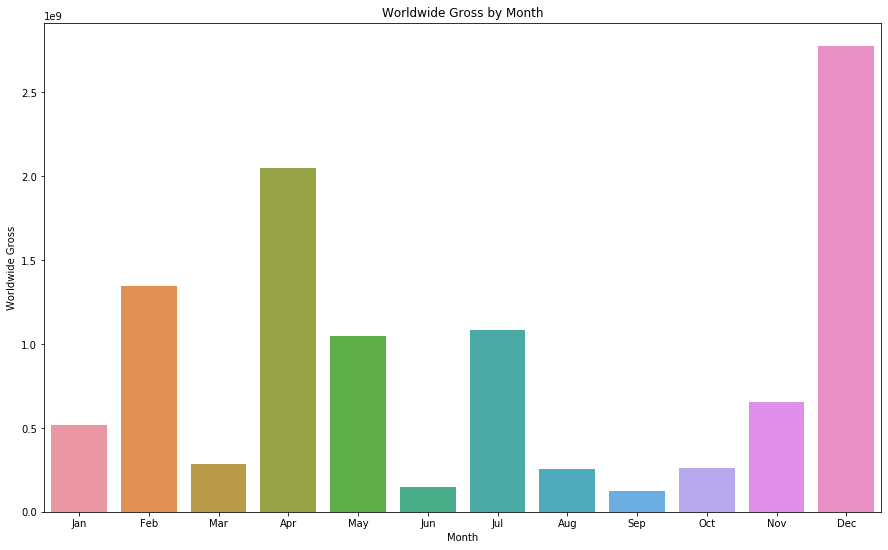

In [11]:
plt.figure(figsize=(15,9))
sns.barplot(x=df['release_month'], y=df['worldwideGross'])
plt.title("Worldwide Gross by Month")
plt.xlabel("Month")
plt.ylabel("Worldwide Gross")
plt.show()

**December**-released movies make the most money by far, followed by **April** and then **February**. This makes sense given the winter holiday season in December, the spring holiday season in April, and Valentine's Day in February.

Surprisingly, however, these high-seasons are fairly narrow: January is a poor-performing month in spite of following December. June and August are terrible box office months despite May and July doing fairly well.

It is worth noting, however, that the data does not truly capture box office by month, but total box office by month of release. We can nevertheless extrapolate that this data shows the best months for the box office, as we generally expect the highest grosses to come from those initial days or weeks of release. But it is good to keep in mind that caveat.

### Per-Movie Basis

Does the answer change if we examine box office results on a per-movie basis?

We can answer this by modifying the SQL query and creating a new variable.

In [12]:
df = pd.read_sql_query('''
    SELECT SUBSTRING(release_date, 1, 3) AS release_month,
           count(id) AS movies_released,
           CAST(REPLACE(REPLACE(production_budget, '$', ''), ',' ,'') AS UNSIGNED) AS productionBudget, 
           CAST(REPLACE(REPLACE(worldwide_gross, '$', ''), ',' ,'') AS UNSIGNED) AS worldwideGross,
           CAST(REPLACE(REPLACE(domestic_gross, '$', ''), ',' ,'') AS UNSIGNED) AS domesticGross,
           CAST(REPLACE(REPLACE(worldwide_gross, '$', ''), ',' ,'') AS UNSIGNED) - CAST(REPLACE(REPLACE(domestic_gross, '$', ''), ',' ,'') AS UNSIGNED) AS internationalGross,
           CAST(REPLACE(REPLACE(worldwide_gross, '$', ''), ',' ,'') AS UNSIGNED) / count(id) AS gross_per_movie
           -- CAST(REPLACE(REPLACE(worldwide_gross, '$', ''), ',' ,'') AS UNSIGNED) - CAST(REPLACE(REPLACE(production_budget, '$', ''), ',' ,'') AS UNSIGNED) AS profit
    FROM tn_movie_budgets
    GROUP BY release_month
    ORDER BY gross_per_movie DESC
''', conn)

In [13]:
three_letter_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
months = pd.DataFrame({'month_mmm': three_letter_months, 'month_mm': [i for i in range(1,13)]})
df = df.merge(months, left_on='release_month', right_on='month_mmm').drop('month_mmm', axis=1).sort_values(by='month_mm')

In [25]:
plt.figure(figsize=(15,9))
sns.barplot(x=df['release_month'], y=df['gross_per_movie'])
plt.title("Worldwide Gross per Movie by Month",fontsize = 16)
plt.xlabel("Month")
plt.ylabel("Worldwide Gross per Movie")
plt.show()

NameError: name 'df' is not defined

<Figure size 1080x648 with 0 Axes>

In fact, **April**, **December**, and **February** retain their top spots as having the highest grossing movies on a per-movie basis. April, however, has now overtaken December as the best month for movies.

**Microsoft should therefore concentrate its release dates in these months.**

## (3) Success by Director

*Who are the most successful directors according to box office sales?*

To answer this question, we need to combine the data from four separate data tables: three from IMDB and one from TN. The tables are joined by person number, title number, and movie title. 

In [20]:
df2=pd.read_sql('''Select primary_name,primary_profession,movie,production_budget,domestic_gross,worldwide_gross
From movies.imdb_title_crew
join imdb_name_basics
on imdb_name_basics.nconst = imdb_title_crew.directors
join imdb_title_basics
on imdb_title_basics.tconst = imdb_title_crew.tconst
join tn_movie_budgets
on imdb_title_basics.primary_title=tn_movie_budgets.movie
where primary_profession like "%director%"''',conn)

The data must be cleaned, as the box office data are given as strings including dollar signs and commas.

In [21]:
df2['worldwide_gross']=df2['worldwide_gross'].str.replace(',','')
df2['worldwide_gross']=df2['worldwide_gross'].str.replace('$','')
df2['worldwide_gross'] = df2.worldwide_gross.astype(float)

In [37]:
g=df2[['primary_name','worldwide_gross']]
g

,primary_name,worldwide_gross
0,Atsushi Wada,2.776345e+09
1,Rob Marshall,1.045664e+09
2,Simon Kinberg,1.497624e+08
3,Joss Whedon,1.403014e+09
4,Zack Snyder,6.559452e+08
...,...,...
3163,Jim Chuchu,0.000000e+00
3164,Graham Wright,1.387110e+05
3165,Bill Yip,9.459600e+04
3166,Ifigeneia Dimitriou,9.459600e+04


In order to see the gross amount by director, we grouped the data by director and added together their worldwide gross values. After sorting from highest grossing to lowest, we took a peek at the top 20 directors.

In [39]:
gbd = g.groupby('primary_name').sum().sort_values('worldwide_gross',ascending=False).head(20)
gbd

,worldwide_gross
primary_name,
Christopher Nolan,3.086180e+09
James Wan,3.083488e+09
Joss Whedon,2.992085e+09
Peter Jackson,2.922948e+09
Michael Bay,2.911998e+09
Atsushi Wada,2.776345e+09
Francis Lawrence,2.543192e+09
Zack Snyder,2.420920e+09
Bryan Singer,2.383073e+09


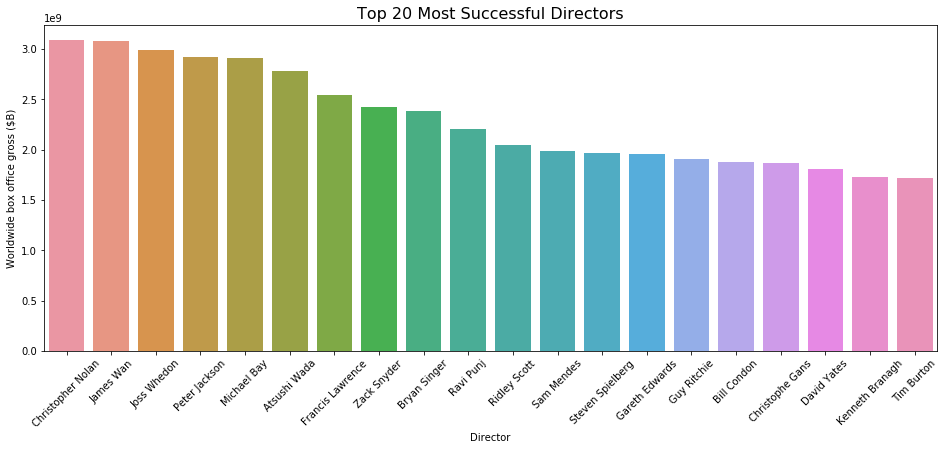

In [48]:
plt.figure(figsize=(16, 6))
sns.barplot(gbd.index,gbd.worldwide_gross)
plt.xlabel('Director')
plt.ylabel('Worldwide box office gross ($B)')
plt.xticks(rotation=45)
plt.title('Top 20 Most Successful Directors',fontsize = 16)
plt.show()

**Findings and recommendation:** Christopher Nolan (The Dark Knight Rises, The Dark Night,Inception) tops the list of highest-grossing directors. **Microsoft should strongly consider trying to sign Nolan for their initial film endeavor.**

It's worth mentioning that there is not a single female director mentioned in the Top 20 chart. This is a sad reality that Microsoft should recognize. If they want to set their film studio apart, they should consider signing a female director. 

## (4) Success by Actor/Actress

*Who are the most successful actors according to box office sales?*

To answer this question, we need to combine the data from four separate data tables: three from IMDB and one from TN. The tables are joined by person number, title number, and movie title. Looking for performers Microsoft should consider casting, it was necessary to include both "actor" and "actress" in the SQL query. 

In [3]:
df4 = pd.read_sql("""SELECT primary_name,movie,worldwide_gross FROM movies.imdb_name_basics
join imdb_title_principals
on imdb_name_basics.nconst = imdb_title_principals.nconst
join imdb_title_basics
on imdb_title_basics.tconst = imdb_title_principals.tconst
join tn_movie_budgets
on imdb_title_basics.primary_title=tn_movie_budgets.movie
where category = 'actress' OR category = 'actor'""", conn)

The data must be cleaned, as the box office data are given as strings including dollar signs and commas.

In [4]:
df4['worldwide_gross']=df4['worldwide_gross'].str.replace(',','')
df4['worldwide_gross']=df4['worldwide_gross'].str.replace('$','')
df4['worldwide_gross'] = df4.worldwide_gross.astype(float)

In order to see the gross amount by actor/actress, we grouped the data by performer and added together their worldwide gross values. After sorting from highest grossing to lowest, we took a peek at the top 25 performers.

In [46]:
actors = df4.groupby('primary_name').sum().sort_values('worldwide_gross', ascending=False).head(25)
actors

,worldwide_gross
primary_name,
Robert Downey Jr.,9.697976e+09
Dwayne Johnson,8.081847e+09
Chris Evans,7.431880e+09
Chris Hemsworth,6.205525e+09
Mark Ruffalo,5.466510e+09
Chris Pratt,5.174777e+09
Jennifer Lawrence,5.156173e+09
Johnny Depp,5.152574e+09
Anne Hathaway,5.001750e+09


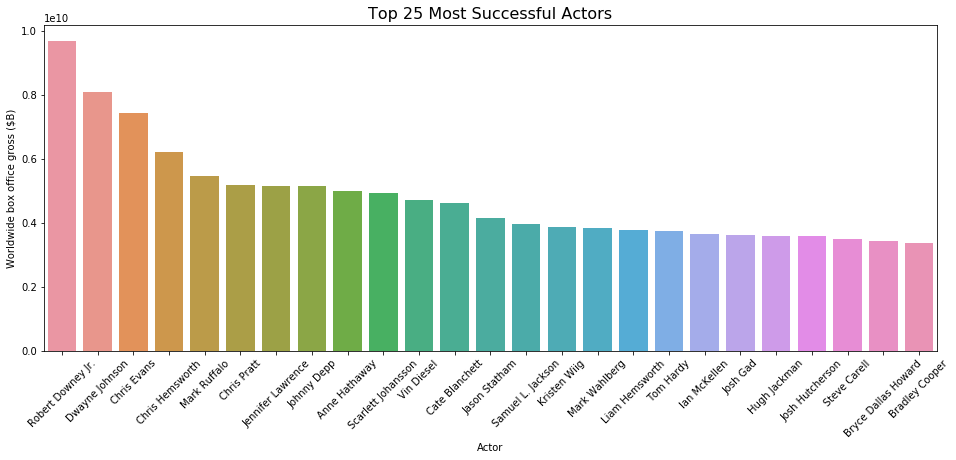

In [50]:
plt.figure(figsize=(16, 6))
sns.barplot(actors.index,actors.worldwide_gross)
plt.xlabel('Actor')
plt.ylabel('Worldwide box office gross ($B)')
plt.xticks(rotation=45)
plt.title('Top 25 Most Successful Actors',fontsize = 16)
plt.show()

**Findings and recommendation:** Robert Downey Jr. is the highest grossing actor due to the box office smash hit of The Avengers series. Meanwhile, Jennifer Lawrence tops the female charts. **Microsoft should strongly consider signing a Top 25 actor/actress for their box office debut.** 

## Limitations and Next Steps

1) **Domestic vs. foreign performance.** These questions are all answered according to worldwide box office figures. If asked to dig deeper into the data, we would zoom in on domestic vs. foreign box office performance to better understand the market segmentation. 

2) **Talent combos.** Our analysis evaluated movie talent in silos: directors, actors, etc. It would be interesting to analyze movie teams (ex. Joss Whedon and Robert Downey Jr.) to understand if there are stellar combinations worth hiring as a package deal.

3) **Correlation between box office figures and popularity.** In our analysis, we selected box office performance as our definition of "best." However, it'd be interesting to compare box office performance to Rotten Tomato scores and see where the top grossing films land on the Tomatometer. 